<a href="https://colab.research.google.com/github/couyang24/general_learning/blob/master/Titanic/analysis/colab_titanic_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Need to mount Drive on or upload kaggle.json

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle/

In [3]:
!cp drive/My\ Drive/input/kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 21.9MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.26MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.1MB/s]


In [5]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394125 sha256=7939bc4b5f5b88ec359fe700a4bbfc505d349720270aceda0b5a98b029d6b50b
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
!pip install catboost

In [6]:
# Load Package
## System
import warnings
warnings.filterwarnings('ignore')

## Data Process
import numpy as np
import pandas as pd
import featuretools as ft

## Visualization
import seaborn as sns
import shap
import matplotlib as plt
import plotly.express as px

## ML Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    LabelEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV 
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model  import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cgb


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
# Load data
train_df= pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [10]:
# Save data
target = train_df[["Survived"]]
submission = test_df[["PassengerId"]]

In [11]:
# Join and Clean
combine = pd.concat([train_df, test_df])

In [12]:
# EDA
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [14]:
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

In [15]:
combine['Title'] = combine.Name.apply(lambda x: x.split(".")[0].split(",")[1].strip()).replace(mapping)

In [18]:
miss_ind = Pipeline(steps=[
    ('indicator', MissingIndicator(error_on_new=False)),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder()),
])

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

In [19]:
combine['Age_MI'] = miss_ind.fit_transform(combine[['Age']])
combine['Cabin_MI'] = miss_ind.fit_transform(combine[['Cabin']])

In [20]:
combine.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

In [21]:
combine[['Sex','Embarked', 'Title']] = categorical_transformer.fit_transform(combine[['Sex', 'Embarked', 'Title']])

In [22]:
combine[['Age', 'Fare']] = numeric_transformer.fit_transform(combine[['Age', 'Fare']])

In [23]:
es = ft.EntitySet(id = 'titanic_data')

es = es.entity_from_dataframe(entity_id = 'combine', dataframe = combine.drop(['Survived'], axis=1), 
                              variable_types = 
                              {
                                  'Embarked': ft.variable_types.Categorical,
                                  'Sex': ft.variable_types.Boolean,
                                  'Title': ft.variable_types.Categorical
                              },
                              index = 'PassengerId')

es

Entityset: titanic_data
  Entities:
    combine [Rows: 1309, Columns: 11]
  Relationships:
    No relationships

In [86]:
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Embarked', index='Embarked')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Sex', index='Sex')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Title', index='Title')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Pclass', index='Pclass')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Parch', index='Parch')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='SibSp', index='SibSp')
es

2020-08-13 00:34:43,739 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: combine.Embarked -> Embarked.Embarked>
2020-08-13 00:34:43,755 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: combine.Sex -> Sex.Sex>
2020-08-13 00:34:43,765 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: combine.Title -> Title.Title>
2020-08-13 00:34:43,771 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: combine.Pclass -> Pclass.Pclass>
2020-08-13 00:34:43,784 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: combine.Parch -> Parch.Parch>
2020-08-13 00:34:43,790 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: combine.SibSp -> SibSp.SibSp>


Entityset: titanic_data
  Entities:
    combine [Rows: 1309, Columns: 11]
    Embarked [Rows: 3, Columns: 1]
    Sex [Rows: 2, Columns: 1]
    Title [Rows: 7, Columns: 1]
    Pclass [Rows: 3, Columns: 1]
    Parch [Rows: 8, Columns: 1]
    SibSp [Rows: 7, Columns: 1]
  Relationships:
    combine.Embarked -> Embarked.Embarked
    combine.Sex -> Sex.Sex
    combine.Title -> Title.Title
    combine.Pclass -> Pclass.Pclass
    combine.Parch -> Parch.Parch
    combine.SibSp -> SibSp.SibSp

In [87]:
features, feature_names = ft.dfs(entityset = es, 
                                 target_entity = 'combine', 
                                 max_depth = 2)

In [88]:
features

Pclass   Age  ...  SibSp.MODE(combine.Sex)  SibSp.MODE(combine.Title)
PassengerId                ...                                                    
1                 3  22.0  ...                      0.0                        3.0
2                 1  38.0  ...                      0.0                        3.0
3                 3  26.0  ...                      1.0                        3.0
4                 1  35.0  ...                      0.0                        3.0
5                 3  35.0  ...                      1.0                        3.0
...             ...   ...  ...                      ...                        ...
1305              3  28.0  ...                      1.0                        3.0
1306              1  39.0  ...                      1.0                        3.0
1307              3  38.5  ...                      1.0                        3.0
1308              3  28.0  ...                      1.0                        3.0
1309              3  28.0  ...                      0.0                        3.0

[1309 rows x 160 columns]

In [89]:
len(feature_names)

160

In [91]:
class RemoveLowInfo(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        keep = [column for column in df.columns if df[column].value_counts(normalize=True).reset_index(drop=True)[0]<self.threshold]
        return df[keep]

In [93]:
impute_median = FunctionTransformer(lambda x: x.fillna(x.median()), validate=False)

In [94]:
normalize = FunctionTransformer(lambda x: (x-x.mean())/x.std(), validate=False)

In [96]:
transformer = Pipeline([
    ("imputer", impute_median),
    ('removelowinfo',RemoveLowInfo(threshold=.99)),
    ('scaler', normalize),
])

In [97]:
clean_features = transformer.fit_transform(features)

In [98]:
clean_features = pd.DataFrame(clean_features)

In [99]:
clean_features.shape

(1309, 128)

In [153]:
methods = [
           ('logistic', LogisticRegression(solver='lbfgs')), 
           ('sgd', SGDClassifier()), 
           ('tree', DecisionTreeClassifier()),
           ('bag', BaggingClassifier()),
           ('xgb', xgb.XGBClassifier(max_depth=3)),
           ('lgb', lgb.LGBMClassifier(max_depth=3)),
           ('cgb', cgb.CatBoostClassifier(max_depth=3,silent=True)),
           ('ada', AdaBoostClassifier()),
           ('gbm', GradientBoostingClassifier()),
           ('rf', RandomForestClassifier(n_estimators=100)),
           ('svc', LinearSVC()),
           ('rbf', SVC()),
           ('nb', Pipeline([('pca', PCA()), ('gnb', GaussianNB())])),
           ('nn', MLPClassifier()),
           ('knn', KNeighborsClassifier()),
          ]

In [154]:
cv = 5

In [155]:
results = []
for method in methods:
  cross_val_scores=cross_val_score(method[1], clean_features.iloc[:train_df.shape[0],:], target, scoring="accuracy", cv=cv)
  results.append([method[0], method[1], cross_val_scores])
  print(method[0], " ", cv, "-fold AUC: ", np.mean(cross_val_scores), sep="")

logistic 5-fold AUC: 0.827154604230745
sgd 5-fold AUC: 0.7520369091707991
tree 5-fold AUC: 0.7957504237022157
bag 5-fold AUC: 0.8047329106772958
xgb 5-fold AUC: 0.8260372857949909
lgb 5-fold AUC: 0.8283095850856821
cgb 5-fold AUC: 0.827154604230745
ada 5-fold AUC: 0.819327098110602
gbm 5-fold AUC: 0.8271483271608814
rf 5-fold AUC: 0.7856694495009731
svc 5-fold AUC: 0.8237838177138912
rbf 5-fold AUC: 0.8237838177138912
nb 5-fold AUC: 0.756443412215178
nn 5-fold AUC: 0.8024982738057875
knn 5-fold AUC: 0.799114933149206


In [156]:
names = [result[0] for result in results]
scores = [result[2] for result in results]

In [157]:
results_ls = [[result[0], score] for result in results for score in result[2]]

In [158]:
results_df = pd.DataFrame(results_ls, columns=['method', 'score'])

In [118]:
# px.box(data_frame=results_df, x='method', y='score', points='all')

[Text(0, 0, 'logistic'),
 Text(0, 0, 'sgd'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'xgb'),
 Text(0, 0, 'lgb'),
 Text(0, 0, 'cgb'),
 Text(0, 0, 'ada'),
 Text(0, 0, 'gbm'),
 Text(0, 0, 'rf'),
 Text(0, 0, 'svc'),
 Text(0, 0, 'rbf'),
 Text(0, 0, 'nb'),
 Text(0, 0, 'nn'),
 Text(0, 0, 'knn')]

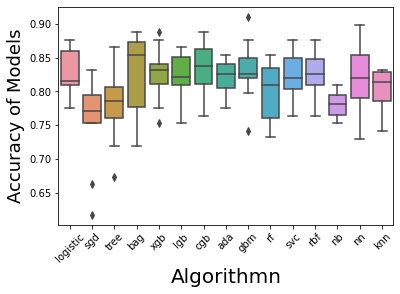

In [119]:
ax = sns.boxplot(x=names, y=scores)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [100]:
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(clean_features.iloc[:train_df.shape[0],:], label=target), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(clean_features.iloc[:train_df.shape[0],:])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], clean_features.iloc[0,:])

In [104]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], clean_features.iloc[:,:])

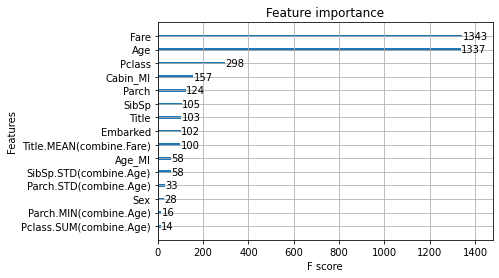

In [103]:
from xgboost import plot_importance
plot_importance(model, max_num_features=15) # top 10 most important features

In [159]:
methods = [
           ('logistic', LogisticRegression(solver='lbfgs')), 
          #  ('sgd', SGDClassifier()), 
          #  ('tree', DecisionTreeClassifier()),
          #  ('bag', BaggingClassifier()),
           ('xgb', xgb.XGBClassifier(max_depth=3)),
           ('lgb', lgb.LGBMClassifier(max_depth=3)),
           ('cgb', cgb.CatBoostClassifier(max_depth=3,silent=True)),
          #  ('ada', AdaBoostClassifier()),
           ('gbm', GradientBoostingClassifier()),
          #  ('rf', RandomForestClassifier(n_estimators=100)),
           ('svc', LinearSVC()),
           ('rbf', SVC()),
          #  ('nb', Pipeline([('pca', PCA()), ('gnb', GaussianNB())])),
          #  ('nn', MLPClassifier()),
          #  ('knn', KNeighborsClassifier()),
          ]

In [160]:
ensemble = VotingClassifier(
        methods,
        voting='soft', 
        weights=[1,1,1,4,1,1,1],
        flatten_transform=True,
)

clf = Pipeline([
#          ('transformer', transformer),
     ('ensemble', ensemble),
])

clf.fit(clean_features.iloc[:train_df.shape[0],:], target)

Pipeline(memory=None,
         steps=[('ensemble',
                 VotingClassifier(estimators=[('logistic',
                                               LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=None,
                                                                  max_iter=100,
                                                                  multi_class='auto',
                                                                  n_jobs=None,
                                                                  penalty='l2',
                                                                  random_st

In [161]:
submission['Survived'] = pd.DataFrame(clf.predict(clean_features.iloc[train_df.shape[0]:,:]))

AttributeError: ignored

In [ ]:
print(submission.dtypes)

In [ ]:
submission.to_csv("submission.csv", index=False)

In [58]:
! kaggle competitions submit -c titanic -f submission.csv -m "Message"